In [2]:
pip install langdetect

     |████████████████████████████████| 981 kB 5.4 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=f94edd3d9bed10b98c0c4d6df8db579014f9a68ef9c4910f41e10df798b0984d
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [3]:
from gensim.models import Word2Vec, KeyedVectors
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.utils import class_weight
import torch
from gensim.scripts.glove2word2vec import glove2word2vec
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pandas as pd
import numpy as np
import random
import re
import os,sys
import torch.nn.functional as F
import time
import gensim
import torch.nn as nn
import nltk
nltk.download('words')
nltk.download('stopwords')
from langdetect import detect
#import contractions
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
embed_size = 100 
max_features = 160000 
maxlen = 300 
batch_size = 64 
SEED = 10
debug = 0

**Raw Dataset without any preprocessing of Lyrics**



In [ ]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP Project/angry_combined_final.csv', usecols=['artist_x','title_x','lyrics','emotion'])
print(len(data))
data.head()



47749


,artist_x,title_x,emotion,lyrics
0,A Balladeer,Winterschläfer,calm,That was your mom who I just informed\nNow go ...
1,A Balladeer,Robin II,sad,"Well, it's been a few days now, so how have yo..."
2,A Balladeer,Hamburg,sad,And then there was\nA flood of tears in secrec...
3,A Day To Remember,You Should Have Killed Me When You Had The Chance,angry,EPISODE 8 - THE PRINCE OF WINTERFELLEXT: WINTE...
4,A Day To Remember,You Had Me At Hello,calm,"I'm missing you so much, I'll see you die toni..."


In [ ]:
rev_rat = data[pd.notnull(data['lyrics'])] #drop lyrics with NAN

In [ ]:
rev_rat = rev_rat.dropna()
rev_rat = rev_rat.reset_index(drop = True)
print(len(rev_rat))
rev_rat.head()

47749


,artist_x,title_x,emotion,lyrics
0,A Balladeer,Winterschläfer,calm,That was your mom who I just informed\nNow go ...
1,A Balladeer,Robin II,sad,"Well, it's been a few days now, so how have yo..."
2,A Balladeer,Hamburg,sad,And then there was\nA flood of tears in secrec...
3,A Day To Remember,You Should Have Killed Me When You Had The Chance,angry,EPISODE 8 - THE PRINCE OF WINTERFELLEXT: WINTE...
4,A Day To Remember,You Had Me At Hello,calm,"I'm missing you so much, I'll see you die toni..."


The final number of songs with an emotion: 47749


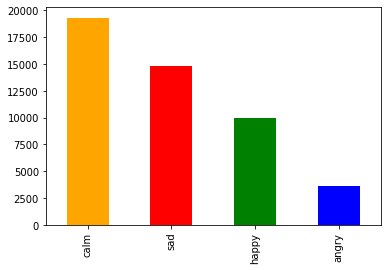

In [ ]:
print('The final number of songs with an emotion:', rev_rat.shape[0])
_ = rev_rat.emotion.value_counts().T.plot(kind='bar',color=['orange', 'red', 'green', 'blue'])

In [ ]:
rev_rat['emotion'].value_counts()

calm     19311
sad      14776
happy    10013
angry     3649
Name: emotion, dtype: int64

## **Find length of each lyrics**

In [ ]:
rev_rat['len'] = rev_rat['lyrics'].apply(lambda s : len(s.split()))
rev_rat.head()

,artist_x,title_x,emotion,lyrics,len
0,A Balladeer,Winterschläfer,calm,That was your mom who I just informed\nNow go ...,151
1,A Balladeer,Robin II,sad,"Well, it's been a few days now, so how have yo...",218
2,A Balladeer,Hamburg,sad,And then there was\nA flood of tears in secrec...,54
3,A Day To Remember,You Should Have Killed Me When You Had The Chance,angry,EPISODE 8 - THE PRINCE OF WINTERFELLEXT: WINTE...,6980
4,A Day To Remember,You Had Me At Hello,calm,"I'm missing you so much, I'll see you die toni...",331


In [ ]:
rev_rat.len.mean()

466.2591677312614

## **Remove all song lyrics which are not English**


In [ ]:
for index, row in rev_rat.iterrows():
  if detect(row['lyrics'])!= 'en':
    rev_rat.loc[index,'lyrics'] = np.NAN




In [ ]:
rev_rat = rev_rat.dropna()
rev_rat = rev_rat.reset_index(drop = True)
len(rev_rat)

44046

In [ ]:
rev_rat.head()

,artist_x,title_x,emotion,lyrics,len
0,A Balladeer,Winterschläfer,calm,That was your mom who I just informed\nNow go ...,151
1,A Balladeer,Robin II,sad,"Well, it's been a few days now, so how have yo...",218
2,A Balladeer,Hamburg,sad,And then there was\nA flood of tears in secrec...,54
3,A Day To Remember,You Should Have Killed Me When You Had The Chance,angry,EPISODE 8 - THE PRINCE OF WINTERFELLEXT: WINTE...,6980
4,A Day To Remember,You Had Me At Hello,calm,"I'm missing you so much, I'll see you die toni...",331


In [ ]:
# rev_rat['emotion'] = np.where((rev_rat.emotion == 'happy'),0,rev_rat.emotion)
# rev_rat['emotion'] = np.where((rev_rat.emotion == 'sad'),1,rev_rat.emotion)
# rev_rat['emotion'] = np.where((rev_rat.emotion == 'calm'),2,rev_rat.emotion)
# rev_rat['emotion'] = np.where((rev_rat.emotion == 'sexy'),3,rev_rat.emotion)

##**Preprocessing the Lyrics**

In [ ]:
import re

def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

In [ ]:
# contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
# def _get_contractions(contraction_dict):
#     contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
#     return contraction_dict, contraction_re
# contractions, contractions_re = _get_contractions(contraction_dict)
# def replace_contractions(text):
#     def replace(match):
#         return contractions[match.group(0)]
#     return contractions_re.sub(replace, text)
# # Usage
# replace_contractions("this's a text with contraction")

In [ ]:
# lower the text
rev_rat["lyrics"] = rev_rat["lyrics"].apply(lambda x: x.lower())

# Clean the text
rev_rat["lyrics"] = rev_rat["lyrics"].apply(lambda x: clean_text(x))

# Clean numbers
rev_rat["lyrics"] = rev_rat["lyrics"].apply(lambda x: clean_numbers(x))

# # Clean Contractions
# rev_rat["lyrics"] = rev_rat["lyrics"].apply(lambda x: replace_contractions(x))

In [ ]:
## remove the HTML and URLs from the reviews
rev_rat['lyrics'] = rev_rat['lyrics'].replace(r'<.*?>+', '', regex=True) #removes html tags
rev_rat['lyrics'] = rev_rat['lyrics'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True) #removes url
## Remove the extra spaces between the words
rev_rat['lyrics']=rev_rat['lyrics'].replace(r'\n+',' ',regex=True) 
rev_rat.head(5)

,artist_x,title_x,emotion,lyrics,len
0,A Balladeer,Winterschläfer,calm,that was your mom who i just informed now go b...,151
1,A Balladeer,Robin II,sad,"well, it's been a few days now, so how have yo...",218
2,A Balladeer,Hamburg,sad,and then there was a flood of tears in secrecy...,54
3,A Day To Remember,You Should Have Killed Me When You Had The Chance,angry,episode 8 - the prince of winterfellext: winte...,6980
4,A Day To Remember,You Had Me At Hello,calm,"i'm missing you so much, i'll see you die toni...",331


In [ ]:
## remove non-alphabetical characters
rev_rat['lyrics'] = rev_rat['lyrics'].replace(r'[^a-zA-Z\' ]+', '', regex=True) #I am not removing apostrophe as they will help in contractions
rev_rat.head(5)

,artist_x,title_x,emotion,lyrics,len
0,A Balladeer,Winterschläfer,calm,that was your mom who i just informed now go b...,151
1,A Balladeer,Robin II,sad,well it's been a few days now so how have you ...,218
2,A Balladeer,Hamburg,sad,and then there was a flood of tears in secrecy...,54
3,A Day To Remember,You Should Have Killed Me When You Had The Chance,angry,episode the prince of winterfellext winterfe...,6980
4,A Day To Remember,You Had Me At Hello,calm,i'm missing you so much i'll see you die tonig...,331


In [ ]:
## Remove the extra spaces between the words
rev_rat['lyrics']=rev_rat['lyrics'].replace(r' +',' ',regex=True) 

In [ ]:
rev_rat.head(5)

,artist_x,title_x,emotion,lyrics,len
0,A Balladeer,Winterschläfer,calm,that was your mom who i just informed now go b...,151
1,A Balladeer,Robin II,sad,well it's been a few days now so how have you ...,218
2,A Balladeer,Hamburg,sad,and then there was a flood of tears in secrecy...,54
3,A Day To Remember,You Should Have Killed Me When You Had The Chance,angry,episode the prince of winterfellext winterfell...,6980
4,A Day To Remember,You Had Me At Hello,calm,i'm missing you so much i'll see you die tonig...,331


In [ ]:
# ## perform contractions on the reviews.
# rev_rat['lyrics']= [contractions.fix(words) for words in rev_rat['lyrics']]


In [ ]:
# remove stop words
st_words = stopwords.words('english')
rev_rat['lyrics'] = rev_rat['lyrics'].apply(lambda x: ' '.join([i for i in x.split() if i not in (st_words)]))

In [ ]:
# ## perform lemmatization  
# lemmatizer = WordNetLemmatizer()
# rev_rat['lyrics']=rev_rat['lyrics'].apply(lambda x: " ".join([lemmatizer.lemmatize(j) for j in nltk.word_tokenize(x)]))


##**Dataset after Preprocessing** 

In [ ]:
rev_rat['len'] = rev_rat['lyrics'].apply(lambda s : len(s.split()))
rev_rat.head()

,artist_x,title_x,emotion,lyrics,len
0,A Balladeer,Winterschläfer,calm,mom informed go back bed still warm one thing ...,66
1,A Balladeer,Robin II,sad,well days know state could care less well bawl...,102
2,A Balladeer,Hamburg,sad,flood tears secrecy questionnaire answered sil...,28
3,A Day To Remember,You Should Have Killed Me When You Had The Chance,angry,episode prince winterfellext winterfell soldie...,3720
4,A Day To Remember,You Had Me At Hello,calm,i'm missing much i'll see die tonight get sun ...,130


In [ ]:
rev_rat.len.mean()

243.3248649139536

##**Saving Cleaned Dataset**

In [ ]:
rev_rat.to_csv('/content/drive/My Drive/Colab Notebooks/NLP Project/angry_combined_final_cleaned_lyrics.csv', index = False)

##**Load the Cleaned Dataset**

In [5]:
rev_rat = pd.read_csv('/content/drive/My Drive/Colab Notebooks/NLP Project/angry_combined_final_cleaned_lyrics.csv', usecols=['artist_x','title_x','lyrics','emotion', 'len'])

In [6]:
index_names = rev_rat[ (rev_rat['len'] < 20)].index # remove
print(len(index_names))
rev_rat.drop(index_names, inplace = True)
rev_rat.reset_index(drop = True)
(rev_rat.head())
rev_rat['len'] = rev_rat['lyrics'].apply(lambda s : len(s.split()))
print(len(rev_rat))
(rev_rat.head())

472
43574


,artist_x,title_x,emotion,lyrics,len
0,A Balladeer,Winterschläfer,calm,mom informed go back bed still warm one thing ...,66
1,A Balladeer,Robin II,sad,well days know state could care less well bawl...,102
2,A Balladeer,Hamburg,sad,flood tears secrecy questionnaire answered sil...,28
3,A Day To Remember,You Should Have Killed Me When You Had The Chance,angry,episode prince winterfellext winterfell soldie...,3720
4,A Day To Remember,You Had Me At Hello,calm,i'm missing much i'll see die tonight get sun ...,130


In [7]:
rev_rat['emotion'].value_counts()

calm     17796
sad      13222
happy     9104
angry     3452
Name: emotion, dtype: int64

## **Split Dataset**

In [8]:
np.random.seed(12)
def split_data(data):
    return np.split(data.sample(frac=1), [int(.8*len(data)), int(.9*len(data))])

df_train, df_dev, df_test = split_data(rev_rat)

In [9]:
print('Train:', df_train.shape)
print('Dev:', df_dev.shape)
print('Test:', df_test.shape)

Train: (34859, 5)
Dev: (4357, 5)
Test: (4358, 5)


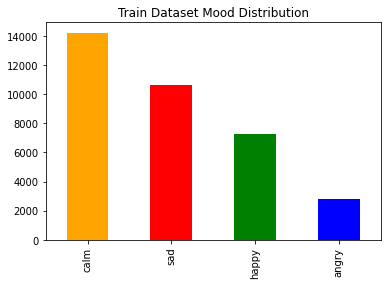

In [10]:
_ = df_train.emotion.value_counts().plot(kind='bar',color=['orange', 'red', 'green', 'blue'], title='Train Dataset Mood Distribution')

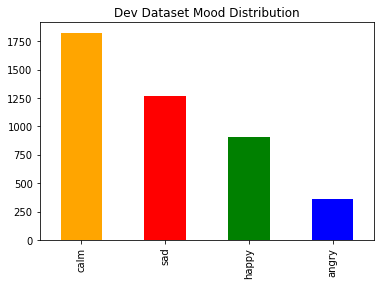

In [11]:
_ = df_dev.emotion.value_counts().plot(kind='bar',color=['orange', 'red', 'green', 'blue'],  title='Dev Dataset Mood Distribution')

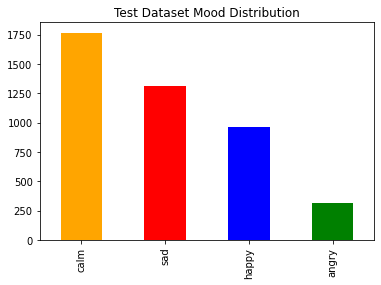

In [12]:
_ = df_test.emotion.value_counts().plot(kind='bar',color=['orange', 'red', 'blue', 'green'], title='Test Dataset Mood Distribution')

## **Baselines with Basic Classification Algorithm**

In [13]:
def pprint_accuracy(acc):
    return '{0:.02f}%'.format(acc * 100)

def most_common_case_classification(x, y):
    assert len(x) == len(y)
    total_count = len(x)
    common_count = y.value_counts().max()
    accuracy = common_count / total_count
    return accuracy

## **Most Common Case Classification**

In [ ]:
print('The most common case for each dataset split is')
print('\tTrain:', df_train.emotion.value_counts().idxmax())
print('\tDev:', df_dev.emotion.value_counts().idxmax())
print('\tTest:', df_test.emotion.value_counts().idxmax())
#df_test.loc[df_test.mood_classes.idxmax()].mood
print('The accuracy of the most-common-case classifier for each dataset split is')
print('\tTrain:', pprint_accuracy(most_common_case_classification(df_train.lyrics, df_train.emotion)))
print('\tDev:', pprint_accuracy(most_common_case_classification(df_dev.lyrics, df_dev.emotion)))
print('\tTest:', pprint_accuracy(most_common_case_classification(df_test.lyrics, df_test.emotion)))

The most common case for each dataset split is
	Train: calm
	Dev: calm
	Test: calm
The accuracy of the most-common-case classifier for each dataset split is
	Train: 40.75%
	Dev: 41.86%
	Test: 40.52%


## **Naive Bayes Classification**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

def prep_lyrics_for_nb(lyrics_series, count_vect=None, tfidf_transformer=None):
   # thank you: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
    if not count_vect:
        count_vect = CountVectorizer()
        count_vect = count_vect.fit(lyrics_series)
    x_train_counts = count_vect.transform(lyrics_series)
    if not tfidf_transformer:
        tfidf_transformer = TfidfTransformer()
        tfidf_transformer = tfidf_transformer.fit(x_train_counts)
    x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
    return count_vect, x_train_counts, tfidf_transformer, x_train_tfidf

# convert lyrics to counts and term-frequencies
count_vect, x_train_counts, tfidf_transformer, x_train_tfidf = prep_lyrics_for_nb(df_train.lyrics)
print(x_train_tfidf.shape)
_, x_dev_counts, _, x_dev_tfidf = prep_lyrics_for_nb(df_dev.lyrics, count_vect, tfidf_transformer)
print(x_dev_tfidf.shape)
_, x_test_counts, _, x_test_tfidf = prep_lyrics_for_nb(df_test.lyrics, count_vect, tfidf_transformer)
print(x_test_tfidf.shape)

(34859, 163751)
(4357, 163751)
(4358, 163751)


In [ ]:
clf = MultinomialNB().fit(x_train_tfidf, df_train.emotion) 
dev_acc = clf.score(x_dev_tfidf, df_dev.emotion)
print('Naive Bayes Classifier Dev Accuracy:', pprint_accuracy(dev_acc))
test_acc = clf.score(x_test_tfidf, df_test.emotion)
print('Naive Bayes Classifier Test Accuracy:', pprint_accuracy(test_acc))

Naive Bayes Classifier Dev Accuracy: 44.14%
Naive Bayes Classifier Test Accuracy: 42.54%


## **SVM Classification**

In [ ]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42,
            max_iter=5, tol=None).fit(x_train_tfidf, df_train.emotion)
dev_acc = clf.score(x_dev_tfidf, df_dev.emotion)
print('SVM Classifier Dev Accuracy:', pprint_accuracy(dev_acc))
test_acc = clf.score(x_test_tfidf, df_test.emotion)
print('SVM Classifier Test Accuracy:', pprint_accuracy(test_acc))

SVM Classifier Dev Accuracy: 55.50%
SVM Classifier Test Accuracy: 54.50%


In [14]:
rev_rat['emotion'] = np.where((rev_rat.emotion == 'happy'),0,rev_rat.emotion)
rev_rat['emotion'] = np.where((rev_rat.emotion == 'sad'),1,rev_rat.emotion)
rev_rat['emotion'] = np.where((rev_rat.emotion == 'calm'),2,rev_rat.emotion)
rev_rat['emotion'] = np.where((rev_rat.emotion == 'angry'),3,rev_rat.emotion)

In [15]:
df_train, df_dev, df_test = split_data(rev_rat)

In [16]:
x_train, y_train = df_train['lyrics'], df_train['emotion']
x_dev, y_dev = df_dev['lyrics'], df_dev['emotion']
x_test, y_test = df_test['lyrics'], df_test['emotion']

In [17]:
# from sklearn.model_selection import train_test_split
# y_orig = rev_rat["emotion"]
# x_train, x_test, y_train, y_test = train_test_split(rev_rat['lyrics'], y_orig, test_size=0.2, random_state=4, stratify = y_orig, shuffle = True)

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
#print(len(x_train[24007]))
print(x_train)


19136    there's train leaving tomorrow yeah i'll free ...
35375    distant shore miles land stands ebony totem eb...
40197    rain comes upon sad sweet earth lie awake nigh...
41818    ran faster caught yes loyalties turned like an...
17433    time year leave hopelessnesses aside little te...
                               ...                        
6783     wohell we're gonna rock rhythm blues tonight r...
7503     come tides coldness waves rides sons darkness ...
27961    took hand took floor time favourite dancer smi...
23806    ladies gentlemen things shapes come freedom's ...
26221    yo swear swear miss times would tie chair teas...
Name: lyrics, Length: 34859, dtype: object


## **Tokenize the sentences**

In [20]:
## Tokenize the sentences
# max_features = 230100
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(x_train))
x_train = tokenizer.texts_to_sequences(list(x_train))
x_test = tokenizer.texts_to_sequences(list(x_test))


## **Pad the sentences**

In [21]:
## Pad the sentences 
x_train_pad = pad_sequences(x_train, maxlen=maxlen,padding='post')
x_test_pad = pad_sequences(x_test, maxlen=maxlen,padding='post')

In [22]:
le = LabelEncoder()
y_train_emotion = le.fit_transform(y_train.values)
y_test_emotion = le.transform(y_test.values)

In [23]:
print(len(x_train_pad[0]))

300


In [24]:
le.classes_

array([0, 1, 2, 3], dtype=object)

## **Load Glove Word Embeddings**

In [25]:
def load_glove(word_index):
    EMBEDDING_FILE = '/content/drive/MyDrive/Colab Notebooks/NLP Project/glove.6B.100d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:100]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [26]:
if debug:
    embedding_matrix = np.random.randn(160000,100)
else:
    embedding_matrix = load_glove(tokenizer.word_index)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [27]:
print(np.shape(embedding_matrix))
print(embed_size)

(160000, 100)
100


## **Neural Network Baseline RNN**

In [67]:
class Lyrics_RNN(nn.Module):
    
    def __init__(self):
        super(Lyrics_RNN, self).__init__()
        self.hidden_size = 256
        drp = 0.33
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size, padding_idx=0)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.RNN(embed_size, self.hidden_size,  batch_first=True)
        self.linear = nn.Linear(self.hidden_size*2 , 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(128, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #lens = get_lengths(x, 0)
        #packed = pack_padded_sequence(h_embedding, lens, batch_first = True, enforce_sorted = False)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        #h_lstm, _ = pad_packed_sequence(h_lstm, batch_first = True, padding_value = 0, total_length = 250)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out
    
    def wt_initalize(self):
        for name, param in self.named_parameters():
            torch.nn.init.normal_(param.data, mean=0, std=0.1)

In [68]:
tag_weightage = torch.FloatTensor(class_weight.compute_class_weight('balanced', classes = np.unique(y_train_emotion), y= y_train_emotion))
print(tag_weightage)

tensor([1.1918, 0.8242, 0.6125, 3.1748])


In [69]:
del model, loss_fn, optimizer

In [70]:
model = Lyrics_RNN()
print(model)

Lyrics_RNN(
  (embedding): Embedding(160000, 100, padding_idx=0)
  (lstm): RNN(100, 256, batch_first=True)
  (linear): Linear(in_features=512, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.33, inplace=False)
  (out): Linear(in_features=128, out_features=4, bias=True)
)


In [71]:
batch_size = 1

In [73]:
n_epochs = 1
model = Lyrics_RNN()
model.wt_initalize()
loss_fn = nn.CrossEntropyLoss(weight = tag_weightage).cuda()
#optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr =0.001)
#scheduler = StepLR(optimizer, step_size = 25) 
model.cuda()

# Load train and test in CUDA Memory
x_train_bilstm = torch.tensor(x_train_pad, dtype=torch.long).cuda()
y_train_bilstm = torch.tensor(y_train_emotion, dtype=torch.long).cuda()
x_cv = torch.tensor(x_test_pad, dtype=torch.long).cuda()
y_cv = torch.tensor(y_test_emotion, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train_bilstm, y_train_bilstm)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=True)

train_loss = []
valid_loss = []
devset_max_accuracy = 0

for epoch in range(n_epochs):
    start_time = time.time()
    y_actual = np.array([])
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    train_preds = np.zeros((len(x_train_bilstm),len(le.classes_)))
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        tr = y_batch.cpu()
        y_actual = np.append(y_actual,tr.numpy())
        y_pred = model(x_batch)
        #y_batch = y_batch
        #print(type(y_pred))
        #print(type(y_batch))
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
        #print('tr:',F.softmax(y_pred).cpu().detach().numpy())
        train_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().detach().numpy()
        #break
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    y_dev_actual = np.array([])
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        tr_dev = y_batch.cpu()
        y_dev_actual = np.append(y_dev_actual,tr_dev.numpy())
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    train_accuracy = sum(train_preds.argmax(axis=1)==y_actual)/len(y_actual)
    val_accuracy = sum(val_preds.argmax(axis=1)==y_dev_actual)/len(y_dev_actual)
    #print(train_preds)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    #scheduler.step(val_accuracy)
    print('Epoch:',epoch+1,'\nTraining Loss:', avg_loss,' Devset Loss:',avg_val_loss, ' Time:',elapsed_time)
    print('Training Accuracy:',train_accuracy,' Devset Accuracy:',val_accuracy)

    if val_accuracy >= devset_max_accuracy:
        print('Devset Accuracy increased hence saving model as checkpoint')
        print("Previous Best:",devset_max_accuracy," Current Best:",val_accuracy)
        torch.save(model.state_dict(), os.path.join(sys.path[0],'angry_lstm_lyrics.pt'))
        devset_max_accuracy = val_accuracy
    # print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t train_acc={:.4f} \ttime={:.2f}s'.format(
    #             epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, train_accuracy, elapsed_time))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[[0.09324758 0.70012629 0.13733481 0.06929135]
 [0.24146563 0.45334059 0.2701225  0.03507124]
 [0.69276661 0.01377205 0.03098335 0.26247799]
 ...
 [0.19136766 0.30672917 0.42603159 0.07587153]
 [0.19133706 0.30669081 0.42610621 0.07586594]
 [0.19129676 0.30663055 0.42621523 0.07585743]]
Epoch: 1 
Training Loss: 1.262468838079825  Devset Loss: 1.2518348788493268  Time: 914.6940503120422
Training Accuracy: 0.4040563412605066  Devset Accuracy: 0.4148692060578247
Devset Accuracy increased hence saving model as checkpoint
Previous Best: 0  Current Best: 0.4148692060578247


## **Create LSTM Model Architecture**

In [ ]:
class Lyrics_LSTM(nn.Module):
    
    def __init__(self):
        super(Lyrics_LSTM, self).__init__()
        self.hidden_size = 256
        drp = 0.33
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size, padding_idx=0)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = True
        self.lstm = nn.LSTM(embed_size, self.hidden_size,  batch_first=True)
        self.linear = nn.Linear(self.hidden_size*2 , 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(128, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #lens = get_lengths(x, 0)
        #packed = pack_padded_sequence(h_embedding, lens, batch_first = True, enforce_sorted = False)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        #h_lstm, _ = pad_packed_sequence(h_lstm, batch_first = True, padding_value = 0, total_length = 250)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out
    
    # def wt_initalize(self):
    #     for name, param in self.named_parameters():
    #         torch.nn.init.normal_(param.data, mean=0, std=0.1)

In [ ]:
tag_weightage = torch.FloatTensor(class_weight.compute_class_weight('balanced', classes = np.unique(y_train_emotion), y= y_train_emotion))
print(tag_weightage)

tensor([1.1918, 0.8242, 0.6125, 3.1748])


In [ ]:
del model, optimizer, loss_fn


In [ ]:
model = Lyrics_LSTM()
print(model)

Lyrics_LSTM(
  (embedding): Embedding(160000, 100, padding_idx=0)
  (lstm): LSTM(100, 256, batch_first=True)
  (linear): Linear(in_features=512, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.33, inplace=False)
  (out): Linear(in_features=128, out_features=4, bias=True)
)


## **Train the LSTM Model**

In [ ]:
n_epochs = 50
model = Lyrics_LSTM()
#model.wt_initalize()
loss_fn = nn.CrossEntropyLoss(reduction='sum',weight = tag_weightage).cuda()
#optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr =0.001)
#scheduler = StepLR(optimizer, step_size = 25) 
model.cuda()

# Load train and test in CUDA Memory
x_train_bilstm = torch.tensor(x_train_pad, dtype=torch.long).cuda()
y_train_bilstm = torch.tensor(y_train_emotion, dtype=torch.long).cuda()
x_cv = torch.tensor(x_test_pad, dtype=torch.long).cuda()
y_cv = torch.tensor(y_test_emotion, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train_bilstm, y_train_bilstm)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=True)

train_loss = []
valid_loss = []
devset_max_accuracy = 0

for epoch in range(n_epochs):
    start_time = time.time()
    y_actual = np.array([])
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    train_preds = np.zeros((len(x_train_bilstm),len(le.classes_)))
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        tr = y_batch.cpu()
        y_actual = np.append(y_actual,tr.numpy())
        y_pred = model(x_batch)
        #y_batch = y_batch
        #print(type(y_pred))
        #print(type(y_batch))
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
        train_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().detach().numpy()
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    y_dev_actual = np.array([])
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        tr_dev = y_batch.cpu()
        y_dev_actual = np.append(y_dev_actual,tr_dev.numpy())
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    train_accuracy = sum(train_preds.argmax(axis=1)==y_actual)/len(y_actual)
    val_accuracy = sum(val_preds.argmax(axis=1)==y_dev_actual)/len(y_dev_actual)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    #scheduler.step(val_accuracy)
    print('Epoch:',epoch+1,'\nTraining Loss:', avg_loss,' Devset Loss:',avg_val_loss, ' Time:',elapsed_time)
    print('Training Accuracy:',train_accuracy,' Devset Accuracy:',val_accuracy)

    if val_accuracy >= devset_max_accuracy:
        print('Devset Accuracy increased hence saving model as checkpoint')
        print("Previous Best:",devset_max_accuracy," Current Best:",val_accuracy)
        torch.save(model.state_dict(), os.path.join(sys.path[0],'angry_lstm_lyrics.pt'))
        devset_max_accuracy = val_accuracy
    # print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t train_acc={:.4f} \ttime={:.2f}s'.format(
    #             epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, train_accuracy, elapsed_time))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 
Training Loss: 80.1520062157868  Devset Loss: 71.96422713044763  Time: 53.2291419506073
Training Accuracy: 0.3583579563383918  Devset Accuracy: 0.40660853602569985
Devset Accuracy increased hence saving model as checkpoint
Previous Best: 0  Current Best: 0.40660853602569985
Epoch: 2 
Training Loss: 66.10864569987733  Devset Loss: 65.01175791975382  Time: 52.24287819862366
Training Accuracy: 0.4903468257838722  Devset Accuracy: 0.5229463056447912
Devset Accuracy increased hence saving model as checkpoint
Previous Best: 0.40660853602569985  Current Best: 0.5229463056447912
Epoch: 3 
Training Loss: 48.860224463086595  Devset Loss: 61.69249552574709  Time: 52.32651138305664
Training Accuracy: 0.6421870965891161  Devset Accuracy: 0.5784763653051859
Devset Accuracy increased hence saving model as checkpoint
Previous Best: 0.5229463056447912  Current Best: 0.5784763653051859
Epoch: 4 
Training Loss: 32.18436898397744  Devset Loss: 71.0920204217883  Time: 52.54979062080383
Training A

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import classification_report
print(classification_report((val_preds.argmax(axis=1)), y_dev_actual))

              precision    recall  f1-score   support

           0       0.64      0.66      0.65       888
           1       0.67      0.64      0.65      1344
           2       0.71      0.70      0.71      1823
           3       0.57      0.62      0.59       303

    accuracy                           0.67      4358
   macro avg       0.65      0.66      0.65      4358
weighted avg       0.67      0.67      0.67      4358



## **Create BiLSTM Model Architecture**

In [ ]:
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 256
        drp = 0.33
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size, padding_idx=0)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(128, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #lens = get_lengths(x, 0)
        #packed = pack_padded_sequence(h_embedding, lens, batch_first = True, enforce_sorted = False)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        #h_lstm, _ = pad_packed_sequence(h_lstm, batch_first = True, padding_value = 0, total_length = 250)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out
    
    def wt_initalize(self):
        for name, param in self.named_parameters():
            torch.nn.init.normal_(param.data, mean=0, std=0.1)

In [ ]:
tag_weightage = torch.FloatTensor(class_weight.compute_class_weight('balanced', classes = np.unique(y_train_emotion), y= y_train_emotion))
print(tag_weightage)

tensor([1.1950, 0.8053, 0.6191, 3.2664])


In [ ]:
del model, optimizer, loss_fn


NameError: ignored

In [ ]:
model = BiLSTM()
print(model)

BiLSTM(
  (embedding): Embedding(160000, 100, padding_idx=0)
  (lstm): LSTM(100, 256, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=1024, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.33, inplace=False)
  (out): Linear(in_features=128, out_features=4, bias=True)
)


In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

In [ ]:
batch_size = 64

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## **Train the BiLSTM Model**

In [ ]:
n_epochs = 50
model = BiLSTM()
model.wt_initalize()
loss_fn = nn.CrossEntropyLoss(weight = tag_weightage).to(device)
#optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr =0.001)
#scheduler = StepLR(optimizer, step_size = 25) 
model.to(device)

# Load train and test in CUDA Memory
x_train_bilstm = torch.tensor(x_train_pad, dtype=torch.long).to(device)
y_train_bilstm = torch.tensor(y_train_emotion, dtype=torch.long).to(device)
x_cv = torch.tensor(x_test_pad, dtype=torch.long).to(device)
y_cv = torch.tensor(y_test_emotion, dtype=torch.long).to(device)

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train_bilstm, y_train_bilstm)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=True)

train_loss = []
valid_loss = []
devset_max_accuracy = 0

for epoch in range(n_epochs):
    start_time = time.time()
    y_actual = np.array([])
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    train_preds = np.zeros((len(x_train_bilstm),len(le.classes_)))
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        tr = y_batch.cpu()
        y_actual = np.append(y_actual,tr.numpy())
        y_pred = model(x_batch)
        #y_batch = y_batch
        #print(type(y_pred))
        #print(type(y_batch))
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
        train_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().detach().numpy()
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    y_dev_actual = np.array([])
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        tr_dev = y_batch.cpu()
        y_dev_actual = np.append(y_dev_actual,tr_dev.numpy())
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    train_accuracy = sum(train_preds.argmax(axis=1)==y_actual)/len(y_actual)
    val_accuracy = sum(val_preds.argmax(axis=1)==y_dev_actual)/len(y_dev_actual)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    #scheduler.step(val_accuracy)
    print('Epoch:',epoch+1,'\nTraining Loss:', avg_loss,' Devset Loss:',avg_val_loss, ' Time:',elapsed_time)
    print('Training Accuracy:',train_accuracy,' Devset Accuracy:',val_accuracy)

    if val_accuracy >= devset_max_accuracy:
        print('Devset Accuracy increased hence saving model as checkpoint')
        print("Previous Best:",devset_max_accuracy," Current Best:",val_accuracy)
        torch.save(model.state_dict(), os.path.join(sys.path[0],'angry_bilstm_lyrics.pt'))
        devset_max_accuracy = val_accuracy
    # print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t train_acc={:.4f} \ttime={:.2f}s'.format(
    #             epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, train_accuracy, elapsed_time))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 
Training Loss: 1.3772984207278547  Devset Loss: 1.3694296964009602  Time: 2050.8223311901093
Training Accuracy: 0.31388552472223685  Devset Accuracy: 0.36815501263689976
Devset Accuracy increased hence saving model as checkpoint
Previous Best: 0  Current Best: 0.36815501263689976
Epoch: 2 
Training Loss: 1.361363135805034  Devset Loss: 1.3420924186706544  Time: 2029.0627987384796
Training Accuracy: 0.3166236638407667  Devset Accuracy: 0.36625947767481043


In [ ]:
from sklearn.metrics import classification_report
print(classification_report((val_preds.argmax(axis=1)), y_dev_actual))

              precision    recall  f1-score   support

           0       0.59      0.73      0.65       723
           1       0.60      0.69      0.65      1142
           2       0.78      0.65      0.71      2147
           3       0.55      0.57      0.56       338

    accuracy                           0.67      4350
   macro avg       0.63      0.66      0.64      4350
weighted avg       0.68      0.67      0.67      4350

